<a href="https://colab.research.google.com/github/cbsobral/python/blob/master/topic_choices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervisor Recommendation Tool - Midterm Report**

In this script, we use "The Natural Language Toolkit" ([nltk](https://www.nltk.org/)) and  [Gensim](https://radimrehurek.com/gensim/) packages to employ Topic Modelling techniques for  classifying the content of the 31 supervisor plans – downloaded from the Hertie School’s mystudies database – into different topics. 

These supervisor plans compose the “corpus” of the work, from which we derive a model that associates topics and supervisors through a propensity score.

Then, we apply the model to the text of a student's research proposal, to extract the best matches between their interests and the topics of our model. 

Finally, we recommend three supervisors that match the student's most prominent topic interest.

Topic modelling is based on the  assumption that each document in a text is a combination of certain topics and that each topic is a combination of related words.

The objective of this script is to extract the underlying topics from the collection of Master Thesis Colloquia Supervisor's plans and compare them to the underlying topics of a student’s research proposal. 

Due to the scope of  our project, our aim is to unveil topics that best represent research interests and/or research methodologies, as these are the main criteria for optimal matching of students and supervisors.



## Data

In [ ]:
# install and update packages
#!pip install pyLDAvis
#!pip install -U gensim

First, we saved the supervisor plans that were downloaded as .pdf in .txt format. 


Then, we uploaded the texts to a G-drive, and imported them to define our corpus.



In [ ]:
# import supervision plans from drive
import nltk
from nltk.corpus import PlaintextCorpusReader
url = (r'/content/drive/My Drive/data/')
corpus_list = PlaintextCorpusReader(url, '.*txt')  # Import all files ending in 'txt'

print(corpus_list.fileids())


['Anheier.txt', 'Bryson.txt', 'Cali.txt', 'Cingolani.txt', 'Costello.txt', 'Dawson.txt', 'Flachsland.txt', 'GohdesHW.txt', 'Graf.txt', 'Hallerberg.txt', 'Hammerschmid.txt', 'Hassel.txt', 'Hirth.txt', 'Hustedt.txt', 'Iacovone.txt', 'Jachtenfuchs.txt', 'Jankin.txt', 'Kayser.txt', 'Kreyenfeld.txt', 'Mair.txt', 'Mena.txt', 'MungiuPippidi.txt', 'Munzert.txt', 'Patz.txt', 'Reh.txt', 'Roemmele.txt', 'Shaikh.txt', 'Snower.txt', 'Stockman.txt', 'Traxler.txt', 'Wegrich.txt']



Before deriving the topics from our corpus, we took some text preprocessing actions:

* **Stopwords removal**: we exclude from the topic modelling analysis words that do not carry substantive meaning, such as “the”, “only” “not”, “own”, etc.
* **Defining additional stopwords**: we define additional words that, in the context of our analysis, do not add substantive value to our topic modelling. The list was constructed by running the topic modelling a few times and checking which irrelevant words kept being signaled as relevant, without being informative of a research/methodological interest. 
* **Lowercasing**: standardizing the words to be analyzed with all lower case characters
* **Lemmatization with WordNet**: transforms words to their root in order allow for a broader matching sample (for example, maps the word “better” as “good”). It is used as an alternative to stemming (which just removes inflections).
* **Punctuation Removal**

Preprocessing our corpus will allows us to extract a group of topics that better represents the substantive and methodological ideas conveyed in the supervisor plans. 

Our aim is to represent concepts by a sample of the most relevant keywords, so, eliminating noise by removing stopwords and punctuation, and standardizing the targets – by lowercasing and lemmatization – should ultimately result in a better model.


In [ ]:
import nltk
from nltk.corpus import stopwords
import gensim
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

wordnet = nltk.WordNetLemmatizer()
stoplist = stopwords.words('english')

# define additional stopwords in a string
additional_stopwords = """question impact professor school dissertation paper take following http nuffield
                          title school session study work topics project partner practice happy plan see supervise
                          research thesis issue design student topic supervision university lab mia mpp"""  

stoplist += additional_stopwords.split()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# convert token to lowercase and stem using the Porter algorithm
def normalize_token(token):
  return wordnet.lemmatize(token.lower())

# evaluate whether or not to retain `token`
def filter_token(token):
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 2

Using gensim, we created a dictionary that contains a map of all words (tokens) present in our corpus and relates them to their unique ids.


With this dictionary, we generate a “bag-of-words” corpus in which the words in the documents were replaced with their respective id (provided by the dictionary).


In [ ]:
# tokenize and apply functions to files
documents=[[normalize_token(token) 
            for token in corpus_list.words(fileids=[fileid])
            if filter_token(token)]
            for fileid in corpus_list.fileids()]

# create bag of words for each document
dictionary = gensim.corpora.Dictionary(documents)         
documents_bow = [dictionary.doc2bow(document) for document in documents]

## Latent Dirichlet Allocation (LDA)  Model

We employed LDA, a generative probabilistic model, to identify the corpus' topics.

The model provides topic probabilities as a representation of the content of a document. The distribution of probabilities, evidently, depends on the number of topics you choose to apply in the LDA model.

We experimented applying different topic quantities into the LDA model, ranging from 5 to 20, and found 10 to be the one that presented more accurate results for content representation.

### Model

In [ ]:
model = gensim.models.LdaModel(documents_bow, 
                               id2word=dictionary,
                               num_topics=10, # best results with 10 topics
                               random_state=123, # seed for consistency
                               passes=500)

### LDA Vis

Here we can see a sample of the probability of certain words being associated with each one of the ten topics. We set the sample of words to displayed to be 7.

In [ ]:
# visualize words per topic
for i, topic in enumerate(model.print_topics(num_topics=10, num_words=7)):
    print (i, ':', topic)

0 : (0, '0.014*"international" + 0.010*"science" + 0.010*"transparency" + 0.007*"organization" + 0.007*"method" + 0.006*"student" + 0.006*"dissertation"')
1 : (1, '0.021*"energy" + 0.018*"electricity" + 0.017*"market" + 0.013*"review" + 0.012*"system" + 0.010*"emission" + 0.009*"generation"')
2 : (2, '0.014*"country" + 0.013*"public" + 0.012*"policy" + 0.012*"medium" + 0.010*"database" + 0.008*"corruption" + 0.008*"ercas"')
3 : (3, '0.016*"public" + 0.016*"policy" + 0.015*"innovation" + 0.013*"lab" + 0.011*"evaluation" + 0.011*"economic" + 0.009*"economics"')
4 : (4, '0.027*"law" + 0.021*"european" + 0.013*"governance" + 0.011*"legal" + 0.011*"policy" + 0.009*"including" + 0.009*"right"')
5 : (5, '0.018*"policy" + 0.016*"political" + 0.014*"analysis" + 0.011*"social" + 0.011*"data" + 0.008*"comparative" + 0.007*"governance"')
6 : (6, '0.025*"health" + 0.011*"data" + 0.010*"social" + 0.008*"http" + 0.007*"inequality" + 0.007*"org" + 0.007*"policy"')
7 : (7, '0.019*"social" + 0.015*"orga

And we generate a table to display the 10 words that appear more frequently in each topic.

In [ ]:
# create table with top 10 words per topic
n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True

Visualization of the table using FacetGrid reveals the words that are substantively associated with the definition of topic content, as well as their relative weight **in the respective topic.** **(Carol, confere se essa parte em negrito ta certa? Acho que dá pra apagar também, mas foi minha interpretação da importância da frequência aqui)**

A quick eyeball exam reveals that we could probably improve our model by adding a few more words to our additional_stopwords list, such as "http", "one" and "org".



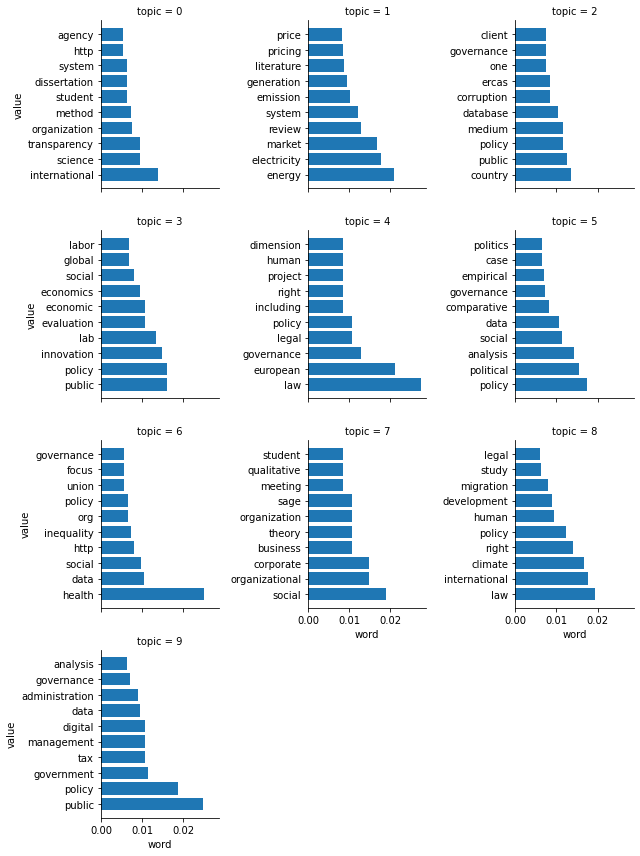

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

# visualize table above
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

Using pyLDAvis function, we can see the words that are most salient in each topic, as well as how topics can overlap in their use of relevant words.

On top of providing a good overview of how our LDA model associated words to topics, this interactive visualization tool helped us define the number of topics to input in the LDA model. Our aim is a good balance of precision and recall, to reach a reasonable coverage of the keywords that best represent ideas of research interests and research methodologies. 

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

# visualize model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, documents_bow, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.047719 -0.055523       1        1  26.145922
9     -0.031767 -0.122022       2        1  19.943593
8     -0.101549  0.161636       3        1  12.581255
6     -0.025539 -0.041619       4        1   9.862240
1      0.226490  0.048692       5        1   8.267060
2     -0.001057 -0.049441       6        1   7.085127
0      0.001506  0.065034       7        1   6.889278
3      0.010311 -0.062997       8        1   4.885952
7      0.001817  0.003602       9        1   2.190055
4     -0.032491  0.052638      10        1   2.149517, topic_info=             Term       Freq       Total Category  logprob  loglift
519           law  32.000000   32.000000  Default  30.0000  30.0000
150        public  80.000000   80.000000  Default  29.0000  29.0000
174        social  56.000000   56.000000  Default  28.0000  28.0000
1311       health  30.000000   30.000000  Default  27.0000  27.0000
487      european  29.000000   29.000000  Default  26.0000  26.0000
...           ...        ...         ...      ...      ...      ...
139        policy   2.263414  129.226386  Topic10  -4.5401  -0.2048
622        europe   0.931974   10.673916  Topic10  -5.4275   1.4017
36    comparative   1.375788   41.935581  Topic10  -5.0380   0.4228
140     political   1.375788   61.282648  Topic10  -5.0380   0.0435
510   institution   0.931974   13.942175  Topic10  -5.4275   1.1346

[696 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
200       5  0.509939            able
200       7  0.339959            able
1842      4  0.877442         academy
202       1  0.202260  accountability
202       2  0.101130  accountability
...     ...       ...             ...
437       2  0.258586            year
437       3  0.129293            year
437       4  0.258586            year
437       7  0.387880            year
1745      3  0.848797             yet

[1248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 9, 7, 2, 3, 1, 4, 8, 5])

Now that we have mapped our topics, we check in each supervisor plan what are the three topics that are more prominant for that specific Master Thesis Colloquium.

The columns of the Table show the Topic number (ranging from 0 to 9), followed by the propoensity score of the association of supervisor plan and said topic.

In [ ]:
# topics per document
documents_lda = model[documents_bow]

# create table with doc_id and most prevalent topics per document
topic_dt = pd.DataFrame(documents_lda)

# supervisor names to index column
topic_dt.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

topic_dt.columns = ['first_topic', 'second_topic', '_third_ topic']
topic_dt.sort_values(['first_topic'], ascending=True, inplace=True)
topic_dt

,first_topic,second_topic,_third_ topic
Patz,"(0, 0.9734325)","(9, 0.023636367)",None
Bryson,"(0, 0.9978257)",None,None
Flachsland,"(1, 0.14515029)","(5, 0.3272048)","(8, 0.52579236)"
Hirth,"(1, 0.9988156)",None,None
MungiuPippidi,"(2, 0.99871033)",None,None
Snower,"(3, 0.9949992)",None,None
Hallerberg,"(3, 0.9970292)",None,None
Dawson,"(4, 0.9957339)",None,None
Hustedt,"(5, 0.7501314)","(9, 0.24634309)",None
Hassel,"(5, 0.98999697)",None,None


And, for good measure, we check the probability of each topic being associated with each supervisor plan.

The resulting Table seems to indicate that Topic 0 is highly assiciated with supervisors Bryson and Patz. 

The results are consistent with those shown in the previous table.

In [ ]:
# topic probabilities per document
topics = [model[documents_bow[i]] for i in range(len(documents))]
num_topics = 10

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

# supervisor names to index column
document_topic.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

document_topic # table with topic probabilities per document

,0,1,2,3,4,5,6,7,8,9
Anheier,0.000000,0.000000,0.00000,0.000000,0.000000,0.996750,0.000000,0.000000,0.000000,0.000000
Bryson,0.997826,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cali,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997142,0.000000
Cingolani,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994443
Costello,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996628,0.000000
Dawson,0.000000,0.000000,0.00000,0.000000,0.995734,0.000000,0.000000,0.000000,0.000000,0.000000
Flachsland,0.000000,0.145149,0.00000,0.000000,0.000000,0.327208,0.000000,0.000000,0.525790,0.000000
GohdesHW,0.000000,0.000000,0.00000,0.000000,0.000000,0.996483,0.000000,0.000000,0.000000,0.000000
Graf,0.000000,0.000000,0.00000,0.000000,0.000000,0.997703,0.000000,0.000000,0.000000,0.000000
Hallerberg,0.000000,0.000000,0.00000,0.997029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### User's Experience - LDA comparison
All of the previous steps concern our topic modelling choices to establish a good model to apply to students' research proposals. As such, we don't expect the final user to have access to - or even be aware of - what goes on "inside the hood" of our Supervisor Recommendation Tool.

In these next lines, we will apply the LDA model to the Students' Master Thesis Proposal. Here, for the first time, our code expects the user to provide for some input: we need them to feed our system with their research proposal. 

We experimented two alternative forms of providing this input:
- 'Add text' allows for students to copy and paste the text of their proposal; and
- 'Add Document' allows for students to provide for a local path where the research proposal is saved, in txt format.

In [ ]:
#@title Add Text { run: "auto", vertical-output: true }

yr_text = "health inequality" #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/ana.txt" #@param {type:"string"}
yr_p = open(path)
yr_path = yr_p.read()

We proceed to tokenize the text provided, to identify the words.
Then, we apply the dictionary to generate a bag-of-words. 

In [ ]:
# tokenize and create bag of words for external document
yr_tokens = nltk.word_tokenize(yr_path)
yr_bow_vector = dictionary.doc2bow(yr_tokens)

We find the three topics that are most prominantly associated with the student's research proposal(as transformed in the bag-of-words). 

In [ ]:
# table with proximity score for top three topics related to external doc
results = pd.DataFrame(model[yr_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

   topic  proximity
7      9   0.267140
6      8   0.196539
1      2   0.177550


Our next step is to display to the Student a list of the top 10 keywords that are more frequent in each of the topics that our model indicated to be the best matches to their proposal. We are still working on how to display this information.

In [ ]:
"""
  from `results` top 3 topics
    print top 10 words by topic
  get input from best topic for user -- yr_topic_input 
"""

'\n  from `results` top 3 topics\n    print top 10 words by topic\n  get input from best topic for user -- yr_topic_input \n'

As a final validation, as well as a way to allow for students to choose what is most relevant for them -- for example, if faced with a choice of which to prioritize, a particular methodological approach or a substantive research interes -- we ask the user to, based on the sample of words we provided, confirm which of the three topics best relates to their research.

In [ ]:
#@title Which topic best relates to your research?
yr_topic_input = 6 #@param {type:"integer"}


Finally, the system provides as our final output, a list of the supervisors better suited to the student's research proposal.

In [ ]:
"""
 from yr_topic_input  -- previous step
    find top 3 related docs in corpus
    find and print top 5 doc_ids
    filter prob > 0
"""
yr_recommend = pd.DataFrame(document_topic.sort_values(yr_topic_input, ascending=False)[yr_topic_input]).head(5)  # from document_topic table
yr_recommend.columns = ['prob']
yr_recommend = yr_recommend[yr_recommend.prob > 0]
print(*yr_recommend.index.tolist(), sep='\n')
#yr_recommend

Shaikh
Mair
Jachtenfuchs
Roemmele


## TF-IDF
+ 12 topics, 15, 9, 6


### Model

In [1]:
#!pip install gensim
from gensim import corpora, models

documents_idf = models.TfidfModel(documents_bow)
corpus_tfidf = documents_idf[documents_bow]

model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                         id2word=dictionary,
                                         num_topics=15, 
                                         random_state=123, 
                                         passes=500)

NameError: ignored

### TF_IDF Vis

In [ ]:
for idx, topic in model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(model_tfidf.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

#topic_words.head()

In [ ]:
import seaborn as sns

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_tfidf, corpus_tfidf, dictionary)
vis

In [ ]:
documents_tfidf = model_tfidf[documents_bow]

topic_dt = pd.DataFrame(documents_tfidf)
doc_dt = pd.DataFrame(file_ids)
conc = pd.concat([doc_dt, topic_dt], axis=1)
#conc.columns = ['doc_id', 'topic1', 'topic2']
#conc.sort_values(['topic1'], ascending=True, inplace=True)
conc

In [ ]:
# table with documents and topic probability
topics = [model_tfidf[documents_bow[i]] for i in range(len(documents))]
num_topics = 9

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

#document_topic

In [ ]:
document_topic.sort_values(6, ascending=False)[6].head(20)

### TF-IDF Comparison


In [ ]:
#@title Add Document{ run: "auto", vertical-output: true }

yr_research = "Social Policy  Research topic: Family Policy, Health Policy, Education Policy, Social Inequality, Child Outcomes, Poverty 2.\tWhat is your research question?  What are the effects of social inequalities on child outcomes? What are the effects of social inequalities on child development? What are the effects of social inequalities on child well-being? To define the specific question the definition of \"child outcomes\", \"child development\" and child \"well-being\" still need to be defined. 3.\tWhy would you like to explore this topic and question? Please let us know why you are curious about your research topic, and why you think your question(s) are worth exploring. I have always been interested in social policy, especially topics related to Child, Youth, and Family Policies. In the past years, I worked with public education and early childhood development in Brazil. Now, I want to expand my view beyond the education area but still analyze the current situation of marginalized children and teenagers. However, I am still not sure if this will be related to the Brazilian or an International context. " #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/stefania.txt" #@param {type:"string"}
yr_p = open(path)
yr_path = yr_p.read()

In [ ]:
# pre-process
yr_tokens = nltk.word_tokenize(yr_path)
yr_bow_vector = dictionary.doc2bow(yr_tokens)

In [ ]:
# data frame with results
results = pd.DataFrame(model_tfidf[yr_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

# References:
- Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.
-[Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.](https://www.jmlr.org/papers/v3/blei03a)
- [Machine Learning Plus 'Gensim Tutorial – A Complete Beginners Guide'](https://www.machinelearningplus.com/nlp/gensim-tutorial/#11howtocreatetopicmodelswithlda)
- [Machine Learning Plus 'Topic modeling visualization – How to present the results of LDA models?'](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)
-[Ganesan,Kavita. 'All you need to know about text preprocessing for NLP and Machine Learning'](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html)

